In [1]:
import os, random, glob, sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(linewidth=sys.maxsize)

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=sys.maxsize)

from core.utils.utils import import_mapf_instance, inverse_sigmoid, get_scene_80, get_sum_of_cost, get_cbs_result, visualize_heatmap
from core.func.cbs_basic import CBSSolver, CBSSolver_Cost_Plot
from core.func.icbs_complete import ICBS_Solver_Compare

In [2]:
def dense_input_data(starts, goals):
    input_data = []

    all_data = [(sx, sy, gx, gy) for (sx, sy), (gx, gy) in zip(starts, goals)]

    for i, (start, goal) in enumerate(zip(starts, goals)):
        sx, sy = start
        gx, gy = goal
        dx, dy = gx-sx, gy-sy
        mag = np.sqrt(dx ** 2 + dy ** 2)

        if mag != 0:
            dx = dx / mag
            dy = dy / mag

        except_agent_data = all_data[:i] + all_data[i+1:]

        own_data = [sx, sy, gx, gy, dx, dy, mag]

        for (other_sx, other_sy, other_gx, other_gy) in except_agent_data:
            other_dx, other_dy = other_gx-other_sx, other_gy-other_sy
            other_mag = np.sqrt(other_dx ** 2 + other_dy ** 2)

            if other_mag != 0:
                other_dx = other_dx / other_mag
                other_dy = other_dy / other_mag

            own_data += [other_sx-sx, other_sy-sy, other_dx, other_dy, other_mag]

        own_data = np.array(own_data)
        input_data.append(own_data)
    
    return np.array(input_data)

In [3]:
class AddCoords(nn.Module):

    def __init__(self, with_r=False):
        super().__init__()
        self.with_r = with_r

    def forward(self, input_tensor):
        """
        Args:
            input_tensor: shape(batch, channel, x_dim, y_dim)
        """
        batch_size, _, x_dim, y_dim = input_tensor.size()

        xx_channel = torch.arange(x_dim).repeat(1, y_dim, 1)
        yy_channel = torch.arange(y_dim).repeat(1, x_dim, 1).transpose(1, 2)

        xx_channel = xx_channel.float() / (x_dim - 1)
        yy_channel = yy_channel.float() / (y_dim - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)
        yy_channel = yy_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)

        ret = torch.cat([
            input_tensor,
            xx_channel.type_as(input_tensor),
            yy_channel.type_as(input_tensor)], dim=1)

        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel.type_as(input_tensor) - 0.5, 2) + torch.pow(yy_channel.type_as(input_tensor) - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)

        return ret

class CoordConv(nn.Module):
    def __init__(self, in_channels, out_channels, with_r=False, **kwargs):
        super().__init__()
        self.addcoords = AddCoords(with_r=with_r)
        in_size = in_channels+2
        if with_r:
            in_size += 1
        self.conv = nn.Conv2d(in_size, out_channels, **kwargs)

    def forward(self, x):
        ret = self.addcoords(x)
        ret = self.conv(ret)
        return ret

In [4]:
class cnn_mlp(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(cnn_mlp, self).__init__()

        self.cnn_layers = nn.Sequential(
            CoordConv(2, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        )
        
        self.flatten = nn.Flatten()
        self.drop_out = nn.Dropout(.2)
        self.mlp_layers = nn.Sequential(
            nn.Linear(input_dim + 512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
        )
    
    def forward(self, obs_map, x):
        obs_feat = self.cnn_layers(obs_map)
        obs_feat = self.flatten(obs_feat)
        x = torch.cat((obs_feat, x), dim=1)
        x = self.mlp_layers(x)
        return x

Sorted_Normalized_no_vertex

In [5]:
test_scene_list = get_scene_80("test_68", "sorted_normalized_nonvertex", dataset="test")
method = "sorted_normalized_nonvertex"
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print("device: {}".format(device))

Total 1139 data loaded for test!
device: cuda:0


In [6]:
BATCH_SIZE = 20
LR = 1e-4
EPOCHS = 386
OBS_MAP = True

model = cnn_mlp(102, 1024)
mseloss = nn.MSELoss()
optm = torch.optim.Adam(model.parameters(), lr=1e-4)

model_name = "cnn_mlp_nonvertex"
loss_name = mseloss._get_name()

if OBS_MAP == False:
    save_path = "/home/railab/Workspace/CCBS/code/model_params/{}/{}/no_obs_map".format(model_name, loss_name)
elif OBS_MAP == True:
    save_path = "/home/railab/Workspace/CCBS/code/model_params/{}/{}/coord_h_val".format(model_name, loss_name)
else:
    raise ValueError(OBS_MAP)

if os.path.exists(save_path):
    saved_model_list = glob.glob(save_path + "/*.pt")
    saved_model_list.sort(key= lambda x : int(x.split("_")[-1][:-3]))
    last_model_file_name = saved_model_list[-1]
    previous_epochs = int(last_model_file_name.split("_")[-1][:-3])

    saved_loss_list = glob.glob(save_path + "/*.txt")[0]
    loss_list = []

    f = open(saved_loss_list, "r")
    saved_loss_list = f.readlines()
    loss_list = [float(saved_loss.rstrip()) for saved_loss in saved_loss_list]

    try:
        model.load_state_dict(torch.load(last_model_file_name))
        print("File name: {}".format(last_model_file_name.split("/")[-1]))
        print("Model loaded successfully")
    except:
        print("Model load Error!")
else:
    previous_epochs = 0
    loss_list = []
    print("There is no trained model!")

print("Model: {}\nLoss: {}\nIs obs_map: {}".format(model_name, loss_name, OBS_MAP))

There is no trained model!
Model: cnn_mlp_nonvertex
Loss: MSELoss
Is obs_map: True


In [7]:
model.eval()
# random.shuffle(test_scene_list)
avg_loss = 0.
for i, scene in enumerate(test_scene_list):
    # if "27104" not in scene:
    #     continue

    # Get data
    test_name = scene.split("/")[-2]
    scene_name = scene.split("/")[-1][:-4]

    map, starts, goals = import_mapf_instance(scene)
    obs_map = np.array([[int(val) for val in sublist] for sublist in map])
    obs_map = np.repeat(obs_map[np.newaxis,:,:], 20, axis=0)

    start_goals = [[(sx, sy), (gx, gy)] for ind, ((sx, sy), (gx, gy)) in enumerate(zip(starts, goals))]
    start_goals.sort(key=lambda x:(x[0], x[1]))
    sorted_starts = np.array([(sx, sy) for [(sx, sy), (gx, gy)] in start_goals])
    sorted_goals = np.array([(gx, gy) for [(sx, sy), (gx, gy)] in start_goals])
    input_data = dense_input_data(sorted_starts, sorted_goals)

    heatmap_path = "/home/railab/Workspace/CCBS/code/costmaps/Gaussian_Blur/" + test_name + "_heatmap/" + method + "/" + scene_name + ".npy"
    heatmap_data = np.load(heatmap_path, allow_pickle=True)

    h_map_path = "/home/railab/Workspace/CCBS/code/h_value_maps/" + method + "/" + scene_name + ".npy"
    h_map_array = np.load(h_map_path, allow_pickle=True)

    # Shuffle input, target pair
    data_pair_list = [[i, input, target, h_map] for i, (input, target, h_map) in enumerate(zip(input_data, heatmap_data, h_map_array))]
    input_list = []
    target_list = []
    h_val_list = []
    for pair in data_pair_list:
        input_list.append(pair[1])
        target_list.append(pair[2])
        h_val_list.append(pair[3])

    input = np.array(input_list)
    h_val = np.array(h_val_list)
    target_ = np.array(target_list)
    target_ = np.where(target_==0, 1e-4, target_)
    target_ = np.where(target_>=1, 1-(1e-4), target_)

    inverse_target = inverse_sigmoid(target_)

    obs_map = torch.reshape(torch.Tensor(obs_map), heatmap_data.shape)
    h_val = torch.reshape(torch.Tensor(h_val), heatmap_data.shape)

    conv_data = torch.cat((obs_map, h_val), axis=1)

    input_data = torch.Tensor(input)
    target = torch.Tensor(inverse_target)

    pred = model(conv_data, input_data)
    pred = torch.reshape(pred, target.shape)

    loss = mseloss(pred, target)

    pred = torch.sigmoid(pred)
    pred = pred.detach().numpy()

    pred = np.where(pred < 0.1, 0, pred)

    # /home/railab/Workspace/CCBS/Results/Making_heatmap/test_68/sorted_normalized_nonvertex/nodes_dec/test_10/test_68_27300_result.txt
    result_file_path = "/home/railab/Workspace/CCBS/Results/Making_heatmap/" + test_name + "/" + method + "/nodes_dec/test_10/" + scene_name + "_result.txt"

    print("Scene: {}".format(scene_name))

    f = open(result_file_path, 'r')
    contents = f.readlines()
    cbs_result = contents[1] + contents[2].rstrip()
    f.close()

    cbs_gen_nodes = int(contents[2].split(", ")[1].split(": ")[1])
    cbs_exp_nodes = int(contents[2].split(", ")[2].split(": ")[1])

    cbs_solver = CBSSolver(map, starts, goals)
    cbs_path, cbs_gen_nodes, cbs_exp_nodes, cbs_total_CT = cbs_solver.find_solution()
    cbs_gen_node_list, cbs_exp_node_list = cbs_solver.get_closed_list()

    l_cbs_solver = CBSSolver_Cost_Plot(map, starts, goals, pred)
    l_cbs_path, l_cbs_gen_nodes, l_cbs_exp_nodes, l_cbs_total_CT = l_cbs_solver.find_solution(cbs_gen_nodes, cbs_exp_nodes)
    l_cbs_gen_node_list, l_cbs_exp_node_list = l_cbs_solver.get_closed_list()

    icbs_solver = ICBS_Solver_Compare(map, starts, goals)
    icbs_path, icbs_gen_nodes, icbs_exp_nodes, icbs_total_CT = icbs_solver.find_solution(False, "a_star")
    icbs_gen_node_list, icbs_exp_node_list = icbs_solver.get_closed_list()

    if l_cbs_path != None:
        # l_cbs_gen_nodes_list, l_cbs_exp_nodes_list = l_cbs_solver.get_closed_list()
        icbs_cost = get_sum_of_cost(icbs_path)
        icbs_result = "\nImproved_CBS results!\nCost: {}, Gen_nodes: {}, Exp_nodes: {}, Total CT: {}".format(icbs_cost, icbs_gen_nodes, icbs_exp_nodes, icbs_total_CT) # 

        l_cbs_cost = get_sum_of_cost(l_cbs_path)

        l_cbs_result = "\nLearned_CBS results!\nCost: {}, Gen_nodes: {}, Exp_nodes: {}, Total CT: {}".format(l_cbs_cost, l_cbs_gen_nodes, l_cbs_exp_nodes, l_cbs_total_CT)
        total_result = cbs_result + icbs_result + l_cbs_result
        print(total_result)

    break

    #     total_result_file_name = "/home/railab/Workspace/CCBS/Train_results/Overfitting/cbs_results/" + scene_name + ".txt"
    #     f = open(total_result_file_name, "w")
    #     f.write(total_result)
    #     f.close()
    # else:
    #     continue

    # # /home/railab/Workspace/CCBS/Train_results/Overfitting/cbs_results
    

Scene: test_68_27300
CBS Astar spent: 0.02632451057434082
CBS High level spent: 0.4298672676086426
USING:  <function standard_splitting at 0x7fb371f90ee0> a_star



> Find Collision Type
Detected semi-cardinal collision. Chose it.
> Take Bypass



> Find Collision Type
No cardinal or semi-cardinal conflict. Randomly choosing...
do not merge
bypass not found



> Find Collision Type
No cardinal or semi-cardinal conflict. Randomly choosing...
do not merge
bypass not found



> Find Collision Type
No cardinal or semi-cardinal conflict. Randomly choosing...
do not merge
bypass not found



> Find Collision Type
No cardinal or semi-cardinal conflict. Randomly choosing...
do not merge
bypass not found



> Find Collision Type
No cardinal or semi-cardinal conflict. Randomly choosing...
do not merge
bypass not found



> Find Collision Type
No cardinal or semi-cardinal conflict. Randomly choosing...
do not merge
bypass not found



> Find Collision Type
No cardinal or semi-cardinal conflict. R

In [8]:
print(len(cbs_gen_node_list))
print(len(icbs_gen_node_list))
print(len(l_cbs_gen_node_list))

for gen_node in cbs_gen_node_list:
    node = gen_node[3]
    cost = node["cost"]
    costraints = node["constraints"]
    collisions = node["collisions"]
    print(cost, len(collisions))
    print("Cons:", costraints, "Cols:", collisions)

for gen_node in icbs_gen_node_list:
    node = gen_node[3]
    cost = node["cost"]
    costraints = node["constraints"]
    collisions = node["ma_collisions"]
    print(cost, len(collisions))
    print("Cons:", costraints, "Cols:", collisions)

for gen_node in l_cbs_gen_node_list:
    node = gen_node[3]
    cost = node["cost"]
    costraints = node["constraints"]
    collisions = node["collisions"]
    print(cost, len(collisions))
    print("Cons:", costraints, "Cols:", collisions)

133
129
9
369 3
Cons: [] Cols: [{'a1': 3, 'a2': 10, 'loc': [(27, 15)], 'timestep': 3}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)], 'timestep': 9}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)], 'timestep': 26}]
369 3
Cons: [{'agent': 1, 'loc': [(25, 27)], 'timestep': 7, 'positive': False, 'meta_agent': {1}}] Cols: [{'a1': 3, 'a2': 10, 'loc': [(27, 15)], 'timestep': 3}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)], 'timestep': 9}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)], 'timestep': 26}]
369 3
Cons: [{'agent': 8, 'loc': [(25, 27)], 'timestep': 7, 'positive': False, 'meta_agent': {8}}] Cols: [{'a1': 3, 'a2': 10, 'loc': [(27, 15)], 'timestep': 3}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)], 'timestep': 9}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)], 'timestep': 26}]
369 3
Cons: [{'agent': 1, 'loc': [(25, 26)], 'timestep': 8, 'positive': False, 'meta_agent': {1}}, {'agent': 1, 'loc': [(25, 27)], 'timestep': 7, 'positive': False, 'meta_agent': {1}}] Cols: [{'a1': 3, 'a2': 10, 'loc': [(27, 15)], 'timestep': 3}, {'a1': 7

In [9]:
import plotly.graph_objects as go
import networkx as nx
from networkx.readwrite import json_graph
from networkx.drawing.nx_pydot import graphviz_layout

CBS CT PLOT

In [10]:
cbs_tree_nodes = []
cbs_sample_nodes = []
for i, gen_node in enumerate(cbs_gen_node_list, start=1):
    node = gen_node[3]
    cost = node["cost"]
    constraints = node["constraints"]
    collisions = node['collisions']

    new_cons = []
    
    if len(constraints) == 0:
        pass
    else:
        for con in constraints:
            # new_cons.append(con['agent'])
            tmp = {"agent": con["agent"]}
            new_cons.append(tmp)

    new_cols = []
    if len(collisions) == 0:
        pass
    else:
        for col in collisions:
            new_col = {'a1': col['a1'], 'a2': col['a2'], 'loc': col['loc']}
            new_cols.append(new_col)
    
    sample_node = {'id': i, "name":"node"+str(i)}
    new_node = {'id': i,'cost': cost, 'cons': new_cons, 'cols': new_cols, "name":"node"+str(i)}
    
    cbs_sample_nodes.append(sample_node)
    cbs_tree_nodes.append(new_node)

for node in cbs_tree_nodes:
    print(node)

{'id': 1, 'cost': 369, 'cons': [], 'cols': [{'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node1'}
{'id': 2, 'cost': 369, 'cons': [{'agent': 1}], 'cols': [{'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node2'}
{'id': 3, 'cost': 369, 'cons': [{'agent': 8}], 'cols': [{'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node3'}
{'id': 4, 'cost': 369, 'cons': [{'agent': 1}, {'agent': 1}], 'cols': [{'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node4'}
{'id': 5, 'cost': 369, 'cons': [{'agent': 8}, {'agent': 1}], 'cols': [{'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node5'}
{'id': 6,

In [11]:
cbs_link_list = []

for i, node in enumerate(cbs_tree_nodes, start=1):
    arrow = {'source': 0, 'target': 0}
    cons = node['cons']
    if len(cons) == 0:
        pass
    elif len(cons) == 1:
        arrow['source'] = 1
        arrow['target'] = i
        cbs_link_list.append(arrow)
    else:
        parent_con = cons[1]
        
        for tmp_node in cbs_tree_nodes:
            if len(tmp_node['cons']) == 0:
                continue
            else:
                if tmp_node['cons'][0] == parent_con:
                    parent_id = tmp_node['id']
                    break
        
        arrow['source'] = parent_id
        arrow['target'] = i
        cbs_link_list.append(arrow)

print(cbs_link_list)

[{'source': 1, 'target': 2}, {'source': 1, 'target': 3}, {'source': 2, 'target': 4}, {'source': 2, 'target': 5}, {'source': 3, 'target': 6}, {'source': 3, 'target': 7}, {'source': 2, 'target': 8}, {'source': 2, 'target': 9}, {'source': 3, 'target': 10}, {'source': 3, 'target': 11}, {'source': 2, 'target': 12}, {'source': 2, 'target': 13}, {'source': 3, 'target': 14}, {'source': 3, 'target': 15}, {'source': 2, 'target': 16}, {'source': 2, 'target': 17}, {'source': 3, 'target': 18}, {'source': 3, 'target': 19}, {'source': 2, 'target': 20}, {'source': 2, 'target': 21}, {'source': 3, 'target': 22}, {'source': 3, 'target': 23}, {'source': 2, 'target': 24}, {'source': 2, 'target': 25}, {'source': 3, 'target': 26}, {'source': 3, 'target': 27}, {'source': 2, 'target': 28}, {'source': 2, 'target': 29}, {'source': 3, 'target': 30}, {'source': 3, 'target': 31}, {'source': 2, 'target': 32}, {'source': 2, 'target': 33}, {'source': 3, 'target': 34}, {'source': 3, 'target': 35}, {'source': 2, 'target

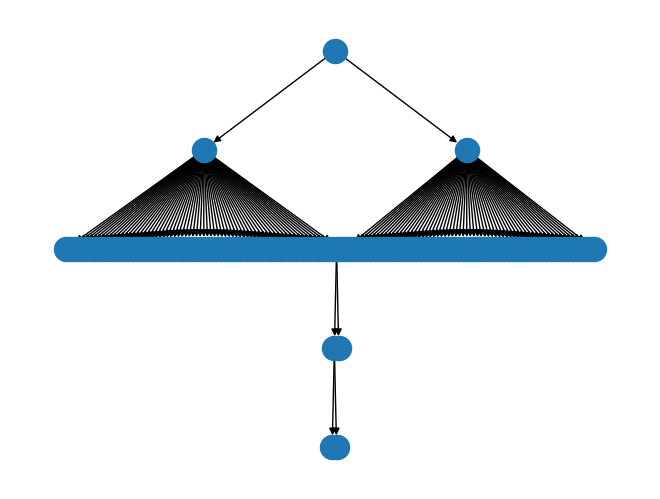

In [12]:
graph_json = {"nodes": cbs_sample_nodes, "links": cbs_link_list}
node_labels = {node['id']:node['name'] for node in graph_json['nodes']}
for n in graph_json['nodes']:
    del n['name']
g = json_graph.node_link_graph(graph_json, directed=True, multigraph=False)
pos = graphviz_layout(g, prog="dot")
new_pos = {}
for i, val in enumerate(pos.values(), start=1):
    new_pos[i] = val
nx.draw(g, new_pos)
plt.show()

ICBS

In [13]:
icbs_tree_nodes = []
icbs_sample_nodes = []
for i, gen_node in enumerate(icbs_gen_node_list, start=1):
    node = gen_node[3]
    cost = node["cost"]
    constraints = node["constraints"]
    collisions = node['ma_collisions']

    new_cons = []
    
    if len(constraints) == 0:
        pass
    else:
        for con in constraints:
            # new_cons.append(con['agent'])
            tmp = {"agent": con["agent"]}
            new_cons.append(tmp)

    new_cols = []
    if len(collisions) == 0:
        pass
    else:
        for col in collisions:
            new_col = {'a1': col['a1'], 'a2': col['a2'], 'loc': col['loc']}
            new_cols.append(new_col)
    
    sample_node = {'id': i, "name":"node"+str(i)}
    new_node = {'id': i,'cost': cost, 'cons': new_cons, 'cols': new_cols, "name":"node"+str(i)}
    
    icbs_sample_nodes.append(sample_node)
    icbs_tree_nodes.append(new_node)

for node in icbs_tree_nodes:
    print(node)

{'id': 1, 'cost': 369, 'cons': [], 'cols': [{'a1': 1, 'a2': 8, 'loc': [(25, 27)]}, {'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node1'}
{'id': 2, 'cost': 369, 'cons': [{'agent': 10}], 'cols': [{'a1': 1, 'a2': 8, 'loc': [(25, 27)]}, {'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}], 'name': 'node2'}
{'id': 3, 'cost': 369, 'cons': [{'agent': 1}, {'agent': 10}], 'cols': [{'a1': 1, 'a2': 8, 'loc': [(25, 26)]}, {'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}], 'name': 'node3'}
{'id': 4, 'cost': 369, 'cons': [{'agent': 8}, {'agent': 10}], 'cols': [{'a1': 1, 'a2': 8, 'loc': [(27, 28)]}, {'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}], 'name': 'node4'}
{'id': 5, 'cost': 369, 'cons': [{'agent': 1}, {'agent': 1}, {'agent': 10}], 'cols': [{'a1': 1, 'a2': 8, 'loc': [(25, 25)]}, {'a1': 3, 'a2': 10, 'loc': [(27, 15)]}, {'a1

In [14]:
icbs_link_list = []

for i, node in enumerate(icbs_tree_nodes, start=1):
    arrow = {'source': 0, 'target': 0}
    cons = node['cons']
    if len(cons) == 0:
        pass
    elif len(cons) == 1:
        arrow['source'] = 1
        arrow['target'] = i
        icbs_link_list.append(arrow)
    else:
        parent_con = cons[1]
        
        for tmp_node in icbs_tree_nodes:
            if len(tmp_node['cons']) == 0:
                continue
            else:
                if tmp_node['cons'][0] == parent_con:
                    parent_id = tmp_node['id']
                    break
        
        arrow['source'] = parent_id
        arrow['target'] = i
        icbs_link_list.append(arrow)

print(icbs_link_list)

[{'source': 1, 'target': 2}, {'source': 2, 'target': 3}, {'source': 2, 'target': 4}, {'source': 3, 'target': 5}, {'source': 3, 'target': 6}, {'source': 4, 'target': 7}, {'source': 4, 'target': 8}, {'source': 3, 'target': 9}, {'source': 3, 'target': 10}, {'source': 4, 'target': 11}, {'source': 4, 'target': 12}, {'source': 3, 'target': 13}, {'source': 3, 'target': 14}, {'source': 4, 'target': 15}, {'source': 4, 'target': 16}, {'source': 3, 'target': 17}, {'source': 3, 'target': 18}, {'source': 4, 'target': 19}, {'source': 4, 'target': 20}, {'source': 3, 'target': 21}, {'source': 3, 'target': 22}, {'source': 4, 'target': 23}, {'source': 4, 'target': 24}, {'source': 3, 'target': 25}, {'source': 3, 'target': 26}, {'source': 4, 'target': 27}, {'source': 4, 'target': 28}, {'source': 3, 'target': 29}, {'source': 3, 'target': 30}, {'source': 4, 'target': 31}, {'source': 4, 'target': 32}, {'source': 3, 'target': 33}, {'source': 3, 'target': 34}, {'source': 4, 'target': 35}, {'source': 4, 'target

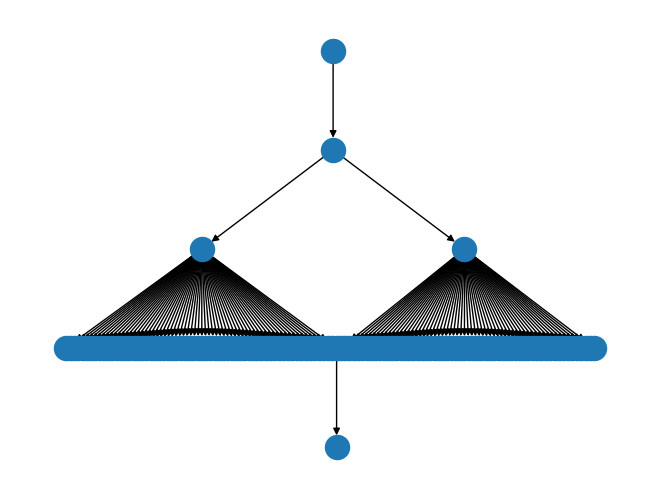

In [15]:
graph_json = {"nodes": icbs_sample_nodes, "links": icbs_link_list}
node_labels = {node['id']:node['name'] for node in graph_json['nodes']}
for n in graph_json['nodes']:
    del n['name']
g = json_graph.node_link_graph(graph_json, directed=True, multigraph=False)
pos = graphviz_layout(g, prog="dot")
new_pos = {}
for i, val in enumerate(pos.values(), start=1):
    new_pos[i] = val
nx.draw(g, new_pos)
plt.show()

In [16]:
l_cbs_tree_nodes = []
l_cbs_sample_nodes = []
for i, gen_node in enumerate(l_cbs_gen_node_list, start=1):
    node = gen_node[3]
    cost = node["cost"]
    constraints = node["constraints"]
    collisions = node['collisions']

    new_cons = []
    if len(constraints) == 0:
        pass
    else:
        for con in constraints:
            # new_cons.append(con['agent'])
            tmp = {"agent": con["agent"]}
            new_cons.append(tmp)

    new_cols = []
    if len(collisions) == 0:
        pass
    else:
        for col in collisions:
            new_col = {'a1': col['a1'], 'a2': col['a2'], 'loc': col['loc']}
            new_cols.append(new_col)
    
    sample_node = {'id': i, "name":"node"+str(i)}
    new_node = {'id': i,'cost': cost, 'cons': new_cons, 'cols': new_cols, "name":"node"+str(i)}
    
    l_cbs_sample_nodes.append(sample_node)
    l_cbs_tree_nodes.append(new_node)

for node in l_cbs_tree_nodes:
    print(node)

{'id': 1, 'cost': 369, 'cons': [], 'cols': [{'a1': 7, 'a2': 13, 'loc': [(18, 27)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node1'}
{'id': 2, 'cost': 369, 'cons': [{'agent': 3}], 'cols': [{'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node2'}
{'id': 3, 'cost': 369, 'cons': [{'agent': 10}], 'cols': [{'a1': 7, 'a2': 13, 'loc': [(18, 27)]}, {'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node3'}
{'id': 4, 'cost': 375, 'cons': [{'agent': 7}, {'agent': 3}], 'cols': [{'a1': 7, 'a2': 15, 'loc': [(18, 22)]}, {'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node4'}
{'id': 5, 'cost': 369, 'cons': [{'agent': 13}, {'agent': 3}], 'cols': [{'a1': 10, 'a2': 16, 'loc': [(15, 26)]}], 'name': 'node5'}
{'id': 6, 'cost': 369, 'cons': [{'agent': 7}, {'agent': 13}, {'agent': 3}], 'cols': [], 'name': 'node6'}
{'id': 7, 'cost': 369, 'cons': [{'agent': 15}, {'agent': 13}, 

In [17]:
l_cbs_link_list = []

for i, node in enumerate(l_cbs_tree_nodes, start=1):
    arrow = {'source': 0, 'target': 0}
    cons = node['cons']
    print(i)
    print(cons)
    if len(cons) == 0:
        pass
    elif len(cons) == 1:
        arrow['source'] = 1
        arrow['target'] = i
        l_cbs_link_list.append(arrow)
        print("Append firt child")
    else:
        parent_con = cons[1]
        for tmp_node in l_cbs_tree_nodes:
            if len(tmp_node['cons']) == 0:
                continue
            else:
                if tmp_node['cons'][0] == parent_con:
                    parent_id = tmp_node['id']
                    break
        arrow['source'] = parent_id
        arrow['target'] = i
        l_cbs_link_list.append(arrow)

print(l_cbs_link_list)

1
[]
2
[{'agent': 3}]
Append firt child
3
[{'agent': 10}]
Append firt child
4
[{'agent': 7}, {'agent': 3}]
5
[{'agent': 13}, {'agent': 3}]
6
[{'agent': 7}, {'agent': 13}, {'agent': 3}]
7
[{'agent': 15}, {'agent': 13}, {'agent': 3}]
8
[{'agent': 10}, {'agent': 7}, {'agent': 13}, {'agent': 3}]
9
[{'agent': 16}, {'agent': 7}, {'agent': 13}, {'agent': 3}]
[{'source': 1, 'target': 2}, {'source': 1, 'target': 3}, {'source': 2, 'target': 4}, {'source': 2, 'target': 5}, {'source': 5, 'target': 6}, {'source': 5, 'target': 7}, {'source': 4, 'target': 8}, {'source': 4, 'target': 9}]


DiGraph with 9 nodes and 8 edges
[1, 2, 3, 4, 5, 6, 7, 8, 9]
{1: (171.0, 234.0), 2: (135.0, 162.0), 3: (207.0, 162.0), 4: (99.0, 90.0), 5: (171.0, 90.0), 6: (171.0, 18.0), 7: (243.0, 18.0), 8: (27.0, 18.0), 9: (99.0, 18.0)}


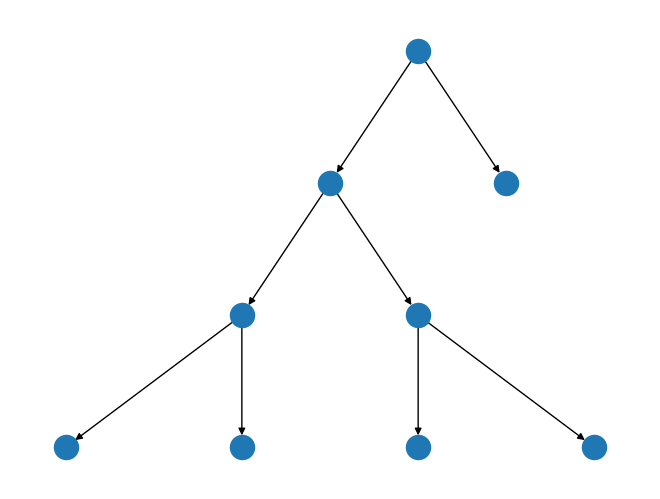

In [18]:
graph_json = {"nodes": l_cbs_sample_nodes, "links": l_cbs_link_list}
node_labels = {node['id']:node['name'] for node in graph_json['nodes']}
for n in graph_json['nodes']:
    del n['name']
g = json_graph.node_link_graph(graph_json, directed=True, multigraph=False)
print(g)
print(g.nodes())
pos = graphviz_layout(g, prog="dot")
new_pos = {}
for i, val in enumerate(pos.values(), start=1):
    new_pos[i] = val
print(new_pos)
nx.draw(g, new_pos)
plt.show()

[1, 2, 3]


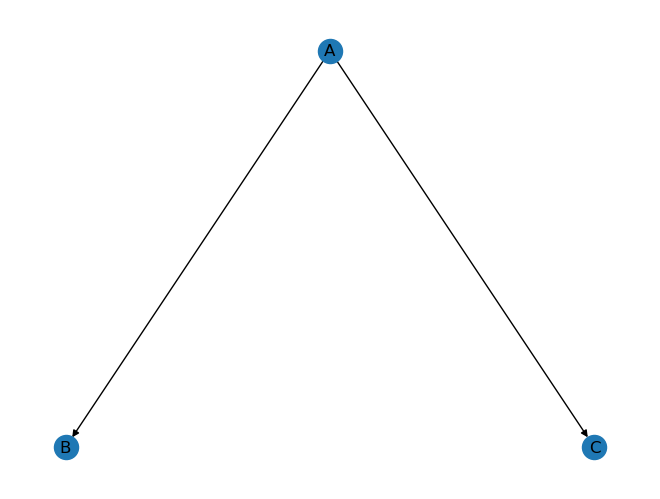

In [19]:
graph_json = {"nodes": [{"id": 1, "name": "A"},{"id": 2, "name": "B"}, {"id":3,"name":"C"}],"links": [{"source":1,"target":2}, {"source":1, "target":3}]}

node_labels = {node['id']:node['name'] for node in graph_json['nodes']}
for n in graph_json['nodes']:
    del n['name']
g = json_graph.node_link_graph(graph_json, directed=True, multigraph=False)
print(g.nodes())
pos = graphviz_layout(g, prog="dot")
new_pos = {}
for i, val in enumerate(pos.values(), start=1):
    new_pos[i] = val
nx.draw(g, new_pos, labels=node_labels, with_labels=True)
plt.show()

In [20]:
# class Linear_Dataset(Dataset):
#     def __init__(self, file_list):
#         self.file_list = file_list
    
#     def __len__(self):
#         return len(self.file_list)
    
#     def __getitem__(self, index):
#         instance_path = self.file_list[index]
#         test_name = instance_path.split("/")[-2]
#         instance_name = instance_path.split("/")[-1][:-4]

#         map, starts, goals = import_mapf_instance(instance_path)
#         obs_map = np.array([[int(val) for val in sublist] for sublist in map])
        
#         start_goals = [[(sx, sy), (gx, gy)] for ind, ((sx, sy), (gx, gy)) in enumerate(zip(starts, goals))]
#         start_goals.sort(key=lambda x:(x[0], x[1]))
#         sorted_starts = np.array([(sx, sy) for [(sx, sy), (gx, gy)] in start_goals])
#         sorted_goals = np.array([(gx, gy) for [(sx, sy), (gx, gy)] in start_goals])
#         input_data = dense_input_data(sorted_starts, sorted_goals)

#         heatmap_path = "/home/railab/Workspace/CCBS/code/costmaps/Gaussian_Blur/" + test_name + "_heatmap/sorted_normalized/" + instance_name + ".npy"
#         heatmap_data = np.load(heatmap_path, allow_pickle=True)

#         target_weight = []
#         for heatmap in heatmap_data:
#             if np.count_nonzero(heatmap) > 0:
#                 target_weight.append(1)
#             else:
#                 target_weight.append(0)

#         return torch.Tensor(obs_map), torch.Tensor(input_data), torch.Tensor(heatmap_data), torch.Tensor(target_weight)

PRIMAL

In [22]:
primal_result_file_list = glob.glob("/home/railab/Workspace/CCBS/Train_results/Overfitting/primal_results/test*")

In [24]:
cost_primal = 

for primal_result_file in primal_result_file_list:
    print(primal_result_file)

    
    
    f = open(primal_result_file, 'r')
    contents = f.readlines()
    print(contents)
    break

/home/railab/Workspace/CCBS/Train_results/Overfitting/primal_results/test_68_27300.txt
['Cost: 423, Targets done: 20, Computation Time(s): 2.34371280670166']
